In [273]:
import io
import pandas as pd
df = pd.read_excel('Mango.xlsx', header=1)

In [274]:
df.columns

Index(['Árbol ', 'Repetición ', 'Exterior L', 'Interior L', 'Exterior A',
       'Interior A', 'Coordenadas', 'Unnamed: 7'],
      dtype='object')

In [275]:
df.columns = ['Arbol','Repeticion', 'Exterior L', 'Interior L', 'Exterior A', 'Interior A','Coordenadas','']

In [276]:
df[df['Arbol']==6]

,Arbol,Repeticion,Exterior L,Interior L,Exterior A,Interior A,Coordenadas,
50,6,1,21.2,13.5,4.9,3.4,NaN,NaN
51,6,2,18.2,18.0,4.5,4.7,NaN,NaN
52,6,3,16.3,17.5,4.2,4.5,NaN,NaN
53,6,4,22.0,16.0,5.4,3.8,NaN,NaN
54,6,5,19.1,21.5,4.0,5.1,NaN,NaN
55,6,6,21.7,15.7,5.7,4.2,NaN,NaN
56,6,7,21.4,15.6,5.2,4.3,NaN,NaN
57,6,8,18.8,16.1,4.7,3.5,NaN,NaN
58,6,9,21.7,15.7,3.8,5.5,NaN,NaN
59,6,10,24.1,20.3,6.3,5.6,NaN,NaN


In [277]:
df_largo = df.melt(
    id_vars=['Arbol', 'Repeticion'],
    value_vars=['Exterior L', 'Interior L'],
    var_name='Ambiente_Largo',
    value_name='Largo'
)

# Paso 2: Melt por ancho (A)
df_ancho = df.melt(
    id_vars=['Arbol', 'Repeticion'],
    value_vars=['Exterior A', 'Interior A'],
    var_name='Ambiente_Ancho',
    value_name='Ancho'
)

# Paso 3: Asegurar orden correcto (por fila)
df_largo = df_largo.sort_values(by=['Arbol', 'Repeticion']).reset_index(drop=True)
df_ancho = df_ancho.sort_values(by=['Arbol', 'Repeticion']).reset_index(drop=True)

# Paso 4: Combinar ancho y largo
df_modelo = pd.DataFrame({
    'Arbol': df_largo['Arbol'],
    'Repeticion': df_largo['Repeticion'],
    'Ambiente': df_largo['Ambiente_Largo'].str.extract(r'(Exterior|Interior)')[0],
    'Largo': df_largo['Largo'],
    'Ancho': df_ancho['Ancho']
})

In [278]:
df_modelo.replace({'L': 'Largo', 'A': 'Ancho'}, inplace=True)

In [279]:
df_modelo['Arbol'] = 'G' + df_modelo['Arbol'].astype(str)

In [280]:
df_modelo.columns = ['Genotipo', 'Repeticion', 'Ambiente', 'Largo', 'Ancho']

## Calculo para los coeficientes de regresión

In [281]:
def calcular_bi_por_caracter(df, caracter):
    # Paso 1: Media por Genotipo y Ambiente
    media_g_a = df.groupby(['Genotipo', 'Ambiente'])[caracter].mean().reset_index()

    # Paso 2: Promedio general (mu)
    mu = df[caracter].mean()

    # Paso 3: Calcular efecto fenotípico
    media_g_a['Efecto fenotipico'] = media_g_a[caracter] - mu

    # Paso 4: Pivotear para tener columnas separadas por ambiente
    pivot_df = media_g_a.pivot(index='Genotipo', columns='Ambiente', values='Efecto fenotipico').reset_index()
    pivot_df.columns.name = None  # Limpiar nombre de columnas

    # Asumimos que los ambientes son 'Exterior' e 'Interior'
    pivot_df = pivot_df.rename(columns={
        'Exterior': 'Efecto_Exterior',
        'Interior': 'Efecto_Interior'
    })

    # Paso 5: Calcular medias ambientales
    medio_exterior = pivot_df['Efecto_Exterior'].mean()
    medio_interior = pivot_df['Efecto_Interior'].mean()

    # Paso 6: Calcular b_i
    def calcular_bi(row):
        num = (row['Efecto_Interior'] * medio_interior) + (row['Efecto_Exterior'] * medio_exterior)
        den = (medio_interior ** 2) * (medio_exterior ** 2)
        return num / den

    pivot_df['b'] = pivot_df.apply(calcular_bi, axis=1)

    return pivot_df


In [295]:
import statsmodels # Import the statsmodels library
statsmodels.__version__

'0.14.4'

In [282]:
import numpy as np
from scipy import stats
import pandas as pd


def Prueba_t_Coeficientes_paralelos(b1, b2, MSE, n=20, df=180):
    SE = np.sqrt(MSE / n)
    estadistico = (b1 - b2)/np.sqrt(2*(MSE/n))
    p_valor = 2 * (1 - stats.t.cdf(abs(estadistico), df=df))
    return pd.Series({
        'b1': b1,
        'b2': b2,
        't': estadistico,
        'p-valor': p_valor,
    })


def Prueba_t_df0(b1,MSE, r = 10):
  estadistico = (b1)/np.sqrt(MSE/(2*r))
  p_valor = 2 * (1 - stats.t.cdf(abs(estadistico), df=180))
  return pd.Series({
      'b1': b1,
      'SE_b1': np.sqrt(MSE/(2*r)),
      't': estadistico,
      'p-valor': p_valor
  })



In [283]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def analizar_varianza(df, variable):
    a = df['Genotipo'].nunique()
    b = df['Ambiente'].nunique()
    r = df.groupby(['Genotipo', 'Ambiente']).size().unique()[0]

    # Crear modelo de ANOVA con interacción
    formula = f'{variable} ~ C(Genotipo) * C(Ambiente)'
    modelo = smf.ols(formula, data=df).fit()
    anova = sm.stats.anova_lm(modelo, typ=2)

    # Calcular suma de cuadrados total (SST)
    SST = ((df[variable] - df[variable].mean()) ** 2).sum()
    df_total = len(df[variable]) - 1

    # Añadir fila "Total" a la tabla ANOVA
    anova.loc['Total'] = [SST, df_total, None, None]

    # Calcular suma de cuadrados del modelo (SS_modelo)
    SS_modelo = (
        anova.loc['C(Genotipo)', 'sum_sq']
        + anova.loc['C(Ambiente)', 'sum_sq']
        + anova.loc['C(Genotipo):C(Ambiente)', 'sum_sq']
    )
    SS_total = SS_modelo + anova.loc['Residual', 'sum_sq']

    # Calcular R^2
    R2 = SS_modelo / SS_total

    # print(f"\nANOVA para {variable}:")
    # print(anova)

    # Extraer cuadrados medios
    MS_G = anova.loc["C(Genotipo)", "sum_sq"] / anova.loc["C(Genotipo)", "df"]
    MS_A = anova.loc["C(Ambiente)", "sum_sq"] / anova.loc["C(Ambiente)", "df"]
    MS_GA = anova.loc["C(Genotipo):C(Ambiente)", "sum_sq"] / anova.loc["C(Genotipo):C(Ambiente)", "df"]
    MS_E = anova.loc["Residual", "sum_sq"] / anova.loc["Residual", "df"]

    # Componentes de varianza
    var_G = (MS_G - MS_E) / (r * b)
    var_A = (MS_A - MS_E) / (r * a)
    var_GA = (MS_GA - MS_E) / r
    var_E = MS_E

    # print(f'\nMsG:  {MS_G:.4f}')
    # print(f'MsA:  {MS_A:.4f}')
    # print(f'MsGA: {MS_GA:.4f}')
    # print(f'MsE:  {MS_E:.4f}')

    # print(f"\nComponentes de varianza para {variable}:")
    # print(f"σ²_G (Genotipo):      {var_G:.4f}")
    # print(f"σ²_A (Ambiente):      {var_A:.4f}")
    # print(f"σ²_GxA (Interacción): {var_GA:.4f}")
    # print(f"σ²_E (Error):         {var_E:.4f}")

    # print(f"\nR² del modelo ({variable}): {R2:.4f}")

    return {
        'σ²_G': var_G,
        'σ²_A': var_A,
        'σ²_GxA': var_GA,
        'σ²_E': var_E,
        'R²': R2,
        'ANOVA': anova,
        'modelo': modelo,
        'MSE': modelo.mse_resid
    }

##Coeficientes distintos a 0 para Largo

In [284]:
MSE = analizar_varianza(df_modelo, 'Largo')['MSE']

df_b = calcular_bi_por_caracter(df_modelo, 'Largo')

resultados = df_b.apply(lambda x: Prueba_t_df0(x['b'],MSE), axis=1)
resultados['genotipo'] = df_b['Genotipo']
resultados.sort_values(by='p-valor')

,b1,SE_b1,t,p-valor,genotipo
9,2.002642,0.803629,2.492000,0.013607,G9
1,1.381696,0.803629,1.719322,0.087275,G10
0,1.361724,0.803629,1.694470,0.091905,G1
8,1.287283,0.803629,1.601839,0.110945,G8
4,1.022201,0.803629,1.271982,0.205020,G4
7,-0.740778,0.803629,-0.921791,0.357871,G7
6,-0.628209,0.803629,-0.781715,0.435409,G6
3,0.586449,0.803629,0.729752,0.466491,G3
5,0.551952,0.803629,0.686825,0.493077,G5
2,-0.412149,0.803629,-0.512859,0.608678,G2


## Comparaciones pruebas paralelas Largo

In [285]:
MSE = analizar_varianza(df_modelo, 'Largo')['MSE']

df_b = calcular_bi_por_caracter(df_modelo, 'Largo')


comparaciones = []

for i in range(len(df_b)):
    for j in range(i+1, len(df_b)):
        g1 = df_b.iloc[i]
        g2 = df_b.iloc[j]
        resultado = Prueba_t_Coeficientes_paralelos(g1['b'], g2['b'], MSE)
        resultado['Genotipo_1'] = g1['Genotipo']
        resultado['Genotipo_2'] = g2['Genotipo']
        comparaciones.append(resultado)

# Resultado final
tabla_resultados = pd.DataFrame(comparaciones)
tabla_resultados = tabla_resultados[['Genotipo_1', 'Genotipo_2', 'b1', 'b2', 't', 'p-valor']]
tabla_resultados[
    ((tabla_resultados['b1'] > 0) & (tabla_resultados['b2'] > 0)) |
    ((tabla_resultados['b1'] < 0) & (tabla_resultados['b2'] < 0))
].sort_values(by='p-valor', ascending=False)


,Genotipo_1,Genotipo_2,b1,b2,t,p-valor
0,G1,G10,1.361724,1.381696,-0.017573,0.985999
25,G3,G5,0.586449,0.551952,0.030354,0.975819
7,G1,G8,1.361724,1.287283,0.065500,0.947849
15,G10,G8,1.381696,1.287283,0.083073,0.933886
39,G6,G7,-0.628209,-0.740778,0.099049,0.921210
20,G2,G6,-0.412149,-0.628209,0.190110,0.849437
33,G4,G8,1.022201,1.287283,-0.233244,0.815837
21,G2,G7,-0.412149,-0.740778,0.289159,0.772793
3,G1,G4,1.361724,1.022201,0.298744,0.765480
11,G10,G4,1.381696,1.022201,0.316317,0.752128


##Coeficientes distintos a 0 para Ancho


In [286]:
MSE = analizar_varianza(df_modelo, 'Ancho')['MSE']

b = calcular_bi_por_caracter(df_modelo, 'Ancho')

resultados = b.apply(lambda x: Prueba_t_df0(x['b'],MSE), axis=1)
resultados['genotipo'] = b['Genotipo']
resultados.sort_values(by='t')

,b1,SE_b1,t,p-valor,genotipo
7,-21.917644,0.199483,-109.872041,0.0,G7
2,-15.068380,0.199483,-75.537028,0.0,G2
6,-9.360660,0.199483,-46.924518,0.0,G6
3,5.022793,0.199483,25.179009,0.0,G3
5,29.223525,0.199483,146.496055,0.0,G5
9,30.593378,0.199483,153.363058,0.0,G9
1,32.648157,0.199483,163.663562,0.0,G10
0,33.561392,0.199483,168.241563,0.0,G1
4,35.387863,0.199483,177.397567,0.0,G4
8,40.867274,0.199483,204.865577,0.0,G8


##Comparaciones pruebas paralelas

In [287]:
MSE = analizar_varianza(df_modelo, 'Ancho')['MSE']

df_b = calcular_bi_por_caracter(df_modelo, 'Ancho')


comparaciones = []

for i in range(len(df_b)):
    for j in range(i+1, len(df_b)):
        g1 = df_b.iloc[i]
        g2 = df_b.iloc[j]
        resultado = Prueba_t_Coeficientes_paralelos(g1['b'], g2['b'], MSE)
        resultado['Genotipo_1'] = g1['Genotipo']
        resultado['Genotipo_2'] = g2['Genotipo']
        comparaciones.append(resultado)

# Resultado final
tabla_resultados = pd.DataFrame(comparaciones)
tabla_resultados = tabla_resultados[['Genotipo_1', 'Genotipo_2', 'b1', 'b2', 't', 'p-valor']]
tabla_resultados[
    ((tabla_resultados['b1'] > 0) & (tabla_resultados['b2'] > 0)) |
    ((tabla_resultados['b1'] < 0) & (tabla_resultados['b2'] < 0))
].sort_values(by='p-valor', ascending=False)

,Genotipo_1,Genotipo_2,b1,b2,t,p-valor
0,G1,G10,33.561392,32.648157,3.237136,1.437352e-03
38,G5,G9,29.223525,30.593378,-4.855704,2.593933e-06
3,G1,G4,33.561392,35.387863,-6.474272,8.778289e-10
16,G10,G9,32.648157,30.593378,7.283556,9.803935e-12
7,G1,G8,33.561392,40.867274,-25.897088,0.000000e+00
8,G1,G9,33.561392,30.593378,10.520692,0.000000e+00
2,G1,G3,33.561392,5.022793,101.160502,0.000000e+00
4,G1,G5,33.561392,29.223525,15.376396,0.000000e+00
11,G10,G4,32.648157,35.387863,-9.711408,0.000000e+00
10,G10,G3,32.648157,5.022793,97.923366,0.000000e+00


In [288]:
df_modelo['Forma'] = df_modelo['Ancho'] / df_modelo['Largo']

In [289]:
# Convert 'Arbol' and 'Repeticion' columns to numeric if they are not already
df['Arbol'] = pd.to_numeric(df['Arbol'], errors='coerce')
df['Repeticion'] = pd.to_numeric(df['Repeticion'], errors='coerce')

# Drop rows with missing values in 'Arbol' or 'Repeticion'
df = df.dropna(subset=['Arbol', 'Repeticion'])

df_export = []
for i in df.columns[2:6]:
    pivotacion = df.pivot(index=[ 'Arbol'], columns='Repeticion', values=i)
    df_export = df_export + [pivotacion]
    print(i)
    print(pivotacion)
    print('\n')


Exterior L
Repeticion    1     2     3     4     5     6     7     8     9     10
Arbol                                                                 
1           19.4  16.3  15.9  13.7  18.2  17.1  18.2  17.3  20.3  12.1
2           18.8  21.7  23.3  22.8  22.7  19.8  23.3  22.8  20.1  18.1
3           24.3  23.0  25.2  20.2  21.7  22.3  24.2  23.7  23.2  18.7
4           26.8  21.4  16.7  18.9  17.9  18.6  16.4  19.5  18.5  21.2
5           12.7  11.6  13.7  14.4  15.1  14.3  15.1  15.0  11.7  21.0
6           21.2  18.2  16.3  22.0  19.1  21.7  21.4  18.8  21.7  24.1
7           18.9  24.0  20.3  19.6  20.6  20.1  18.0  21.6  20.2  23.8
8           29.2  18.1  22.0  20.3  18.7  20.4  17.1  21.4  15.4  14.5
9           19.6  22.7   8.6   8.2  12.1   8.5  11.2   6.8  11.2  20.0
10          16.0  19.8  20.7  23.7  13.9  19.1  21.7  15.3  18.1  15.5


Interior L
Repeticion    1     2     3     4     5     6     7     8     9     10
Arbol                                                

In [296]:
#Largo

import io
import pandas as pd
df_largo = pd.read_csv(io.StringIO('''
G,ee,amb,ambiente
P1,"-2,274","-1,766",e1
P2,"0,464","-1,766",e1
P3,"2,760","-1,766",e1
P4,"0,131","-1,766",e1
P5,"-5,464","-1,766",e1
P6,"-0,640","-1,766",e1
P7,"-0,491","-1,766",e1
P8,"0,513","-1,766",e1
P9,"-5,601","-1,766",e1
P10,"-0,724","-1,766",e1
P1,"2,536","1,766",e2
P2,"-0,992","1,766",e2
P3,"4,832","1,766",e2
P4,"3,741","1,766",e2
P5,"-3,514","1,766",e2
P6,"-2,858","1,766",e2
P7,"-3,107","1,766",e2
P8,"5,059","1,766",e2
P9,"1,473","1,766",e2
P10,"4,156","1,766",e2
'''), header=0)


In [297]:
#ANcho

df_Ancho = pd.read_csv(io.StringIO('''
G,ee,amb
P1,-0.601,-0.353
P2,-0.051,-0.353
P3,0.449,-0.353
P4,0.019,-0.353
P5,-1.741,-0.353
P6,-0.151,-0.353
P7,0.059,-0.353
P8,-0.321,-0.353
P9,-0.981,-0.353
P10,-0.211,-0.353
P1,0.869,0.352
P2,-0.711,0.352
P3,0.669,0.352
P4,1.570,0.352
P5,-0.461,0.352
P6,-0.561,0.352
P7,-0.901,0.352
P8,1.470,0.352
P9,0.359,0.352
P10,1.220,0.352
'''), header=0)


In [301]:
df_Ancho.head()

,G,ee,amb
0,P1,-0.601,-0.353
1,P2,-0.051,-0.353
2,P3,0.449,-0.353
3,P4,0.019,-0.353
4,P5,-1.741,-0.353


In [298]:
df_largo['ee'] = df_largo['ee'].astype(str).str.replace(',', '.').str.strip()

df_largo['ee'] = pd.to_numeric(df_largo['ee'], errors='coerce')

In [302]:
df_Ancho['ee'] = df_Ancho['ee'].astype(str).str.replace(',', '.').str.strip()

df_Ancho['ee'] = pd.to_numeric(df_Ancho['ee'], errors='coerce')

In [303]:
df_largo.replace({df_largo['amb'].unique()[0]: 'A1 (Exterior)\n-1,766', df_largo['amb'].unique()[1]: 'A2 (Interior)\n1,766'}, inplace=True)


In [305]:
df_Ancho.replace({df_Ancho['amb'].unique()[0]: 'A1 (Exterior)\n-0,353', df_Ancho['amb'].unique()[1]: 'A2 (Interior)\n0,353'}, inplace=True)

In [314]:
df_Ancho['G'] = df_Ancho['G'].str.replace('P', 'G')
df_largo['G'] = df_largo['G'].str.replace('P', 'G')

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.edgecolor': 'black',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': 'lightgray',
    'grid.linestyle': '--',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.bottom': False,
    'ytick.left': False
})

##Normas de reacción Ancho

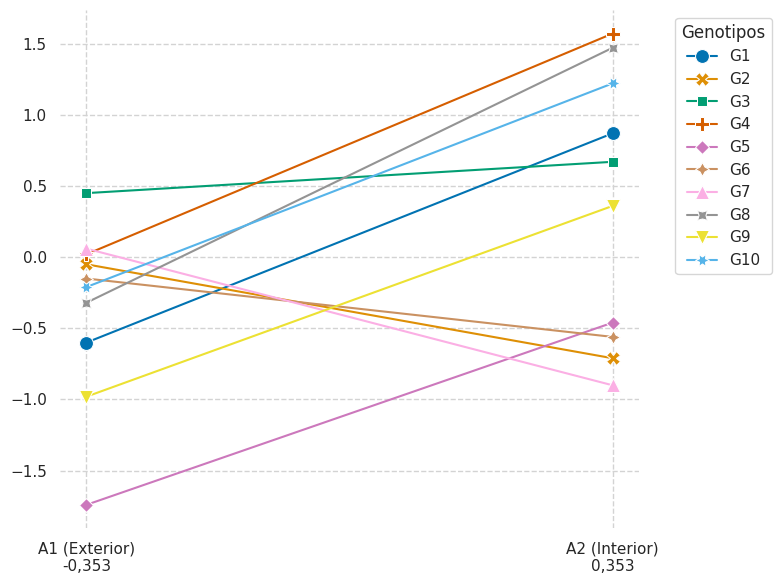

In [315]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')
plt.figure(figsize=(8, 6))

sns.lineplot(
    data=df_Ancho,
    x='amb',
    y='ee',
    hue='G',
    style='G',
    markers=True,
    dashes=False,
    palette='colorblind',
     markersize=10
)

plt.xlabel('')
plt.ylabel('')
plt.legend(title='Genotipos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##Normas de reacción Largo

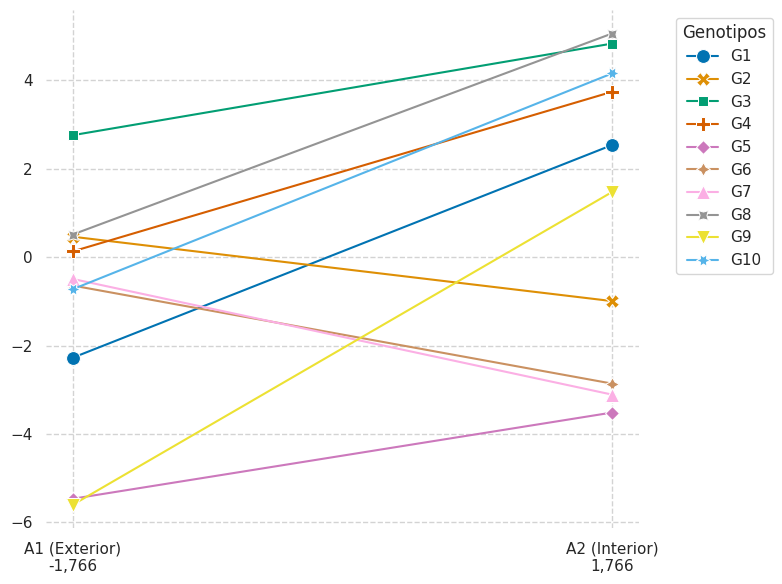

In [316]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')
plt.figure(figsize=(8, 6))

sns.lineplot(
    data=df_largo,
    x='amb',
    y='ee',
    hue='G',
    style='G',
    markers=True,
    dashes=False,
    palette='colorblind',
     markersize=10
)

plt.xlabel('')
plt.ylabel('')
plt.legend(title='Genotipos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()